## **Project Report**

*Note: To run this notebook without error and render the report above, please run all the code below this cell first*

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier
from xgboost import plot_tree

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [50]:
# import data
train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')
submission_df = pd.read_csv('../data/sample_submission.csv')

## Data Preparation for model training

In [56]:
cols_to_drop = ['id', 'CustomerId', 'Surname']
X_train = train_df.drop(cols_to_drop, axis=1).copy()
X_train.drop('Exited', axis=1, inplace=True)
y_train = train_df['Exited'].copy()

X_test = test_df.drop(cols_to_drop, axis=1).copy()

### 1. One Hot Encoding Categorical Variables: 

In [52]:
dummies_col = ['Geography', 'Gender', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']

X_train = pd.get_dummies(X_train, columns=dummies_col, drop_first=True)
X_train.head()

,CreditScore,Age,Tenure,Balance,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4,HasCrCard_1.0,IsActiveMember_1.0
0,668,33.0,3,0.00,181449.97,False,False,True,True,False,False,True,False
1,627,33.0,1,0.00,49503.50,False,False,True,True,False,False,True,True
2,678,40.0,10,0.00,184866.69,False,False,True,True,False,False,True,False
3,581,34.0,2,148882.54,84560.88,False,False,True,False,False,False,True,True
4,716,33.0,5,0.00,15068.83,False,True,True,True,False,False,True,True


In [53]:
# Checking the ratio of the target variable
y_train.value_counts(normalize=True)

Exited
0    0.788401
1    0.211599
Name: proportion, dtype: float64

The distribution of target label (0 and 1) are highly imbalanced: almost 80% of the data is of label 0 (non-exited), label 1 only accounts for ~20%. 

### 2. Feature Scaling

In [54]:
scale_col = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']
print("Before scaling, training data summary: ")    
display(X_train[scale_col].describe().round(2))

# Scale both train and test data
for col in scale_col:
    min_val = X_train[col].min()
    max_val = X_train[col].max()
    X_train[col] = (X_train[col] - min_val) / (max_val - min_val)
    X_test[col] = (X_test[col] - min_val) / (max_val - min_val)

print("After scaling, training data summary: ")
display(X_train[scale_col].describe().round(2))

Before scaling, training data summary: 


,CreditScore,Age,Tenure,Balance,EstimatedSalary
count,165034.00,165034.00,165034.00,165034.00,165034.00
mean,656.45,38.13,5.02,55478.09,112574.82
std,80.10,8.87,2.81,62817.66,50292.87
min,350.00,18.00,0.00,0.00,11.58
25%,597.00,32.00,3.00,0.00,74637.57
50%,659.00,37.00,5.00,0.00,117948.00
75%,710.00,42.00,7.00,119939.52,155152.47
max,850.00,92.00,10.00,250898.09,199992.48


After scaling, training data summary: 


,CreditScore,Age,Tenure,Balance,EstimatedSalary
count,165034.00,165034.00,165034.00,165034.00,165034.00
mean,0.61,0.27,0.50,0.22,0.56
std,0.16,0.12,0.28,0.25,0.25
min,0.00,0.00,0.00,0.00,0.00
25%,0.49,0.19,0.30,0.00,0.37
50%,0.62,0.26,0.50,0.00,0.59
75%,0.72,0.32,0.70,0.48,0.78
max,1.00,1.00,1.00,1.00,1.00


In [36]:
scale_col = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']
print("Before scaling")
display(X[scale_col].describe().round(2))


# Scale the columns
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X[scale_col] = scaler.fit_transform(X[scale_col])
print("After scaling")
display(X[scale_col].describe().round(2))

Before scaling


,CreditScore,Age,Tenure,Balance,EstimatedSalary
count,165034.00,165034.00,165034.00,165034.00,165034.00
mean,656.45,38.13,5.02,55478.09,112574.82
std,80.10,8.87,2.81,62817.66,50292.87
min,350.00,18.00,0.00,0.00,11.58
25%,597.00,32.00,3.00,0.00,74637.57
50%,659.00,37.00,5.00,0.00,117948.00
75%,710.00,42.00,7.00,119939.52,155152.47
max,850.00,92.00,10.00,250898.09,199992.48


After scaling


,CreditScore,Age,Tenure,Balance,EstimatedSalary
count,165034.00,165034.00,165034.00,165034.00,165034.00
mean,-0.00,0.00,-0.00,-0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00
min,-3.83,-2.27,-1.79,-0.88,-2.24
25%,-0.74,-0.69,-0.72,-0.88,-0.75
50%,0.03,-0.13,-0.01,-0.88,0.11
75%,0.67,0.44,0.71,1.03,0.85
max,2.42,6.08,1.77,3.11,1.74


In [55]:
# Splitting Data into Train and Test:
# X_train, X_test, y_train, y_test = train_test_split(X, y, 
#                                                     random_state=1, 
#                                                     stratify=y)
# Checking the ratio of the label after splitting into train and test: 
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

Exited
0    0.788401
1    0.211599
Name: proportion, dtype: float64
Exited
0    0.78841
1    0.21159
Name: proportion, dtype: float64


We keep the same 

## Model Training

### 1. Creating Baseline Model: 

In [ ]:
# Building base line model
xgb_1 = XGBClassifier(objective='binary:logistic', 
                      seed=1)
xgb_1.fit(X_train, y_train, verbose=True, 
            early_stopping_rounds=10, eval_metric='auc', eval_set=[(X_test, y_test)])

In [26]:
# Get all evaluation metrics on the test set
y_pred = xgb_1.predict(X_test)
print(classification_report(y_test, y_pred))

conf_matrix_baseline = confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.89      0.94      0.92     32529
           1       0.73      0.55      0.63      8730

    accuracy                           0.86     41259
   macro avg       0.81      0.75      0.77     41259
weighted avg       0.85      0.86      0.85     41259



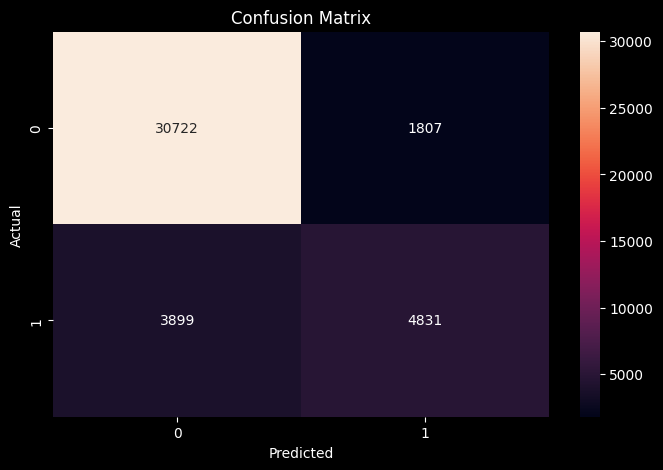

In [27]:
# Function to plot confusion matrix
def plot_confusion_matrix(conf_matrix):
    plt.figure(figsize=(8, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# Plot confusion matrix
plot_confusion_matrix(conf_matrix_baseline)

We can draw some initial conclusions for **the baseline model** (Note: we define 0 is negative and 1 is positive): 
- True Negative, or predicted 0 (non-exited) and actually 0: **30722** 
- True Positive, or predicted 1 (exited) and actually 1: **4831**
- False Negative, or predicted 0 (non-exited) but actually 1 (exited): **3899**
- False Positive, or predicted 1 (exited) but actually 0 (non-exited): **1807**

Next are some business-centric measures that is crucial in churn evaluation problem: 
- **False Negative (FN)** is an important measure for churn problem - the business does not want to under-value customers that would exit (1) by classifying them as non-exit (0) - because the cost of new customer acquisition is generally higher than the cost of keeping the customer. Ideally, the model should minimize the FN number. 
- **False Negative Rate, $FNR = \frac{{FN}}{P} = \frac{{FN}}{FN + TP}$** essentially means: out of all **actually exited customers**, what is the percentage of the customers does the model fail to capture. In this baseline model, $FNR = 44.66\%$. This is a very high rate and our goal is to drive that down. 
- The Precision, 
- The AUC-ROC 

### 2. Model Hyperparameter Tuning and Cross-Validation: 

- Since the dataset is imbalanced with more negative-label data than positive-label data, we could use `scale_pos_weight` to deal with the imbalance

In [ ]:
from sklearn.model_selection import GridSearchCV

xgb_param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'reg_lambda': [0.1, 0.5, 1.0, 10.0],
    'gamma': [0, 0.25, 1.0],
    'scale_pos_weight': [1, 3, 5]
}

opt_param = GridSearchCV(estimator=XGBClassifier(objective='binary:logistic',
                                                seed=1,
                                                subsample=0.9,
                                                colsample_bytree=0.5),
                        param_grid=xgb_param_grid,
                        scoring='roc_auc',
                        verbose=3,
                        n_jobs=10,
                        cv=3)
opt_param.fit(X_train, y_train, 
                early_stopping_rounds=10,
                eval_metric='auc',
                eval_set=[(X_test, y_test)],
                verbose=True) 

In [15]:
print('Best parameters found: ')
print(opt_param.best_params_)

Best parameters found: 
{'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 5, 'reg_lambda': 10.0, 'scale_pos_weight': 5}


In [16]:
# Get all evaluation metrics on the test set
opt_xgb = XGBClassifier(objective='binary:logistic',
                        seed=1,
                        max_depth=5,
                        learning_rate=0.1,
                        reg_lambda=10.0,
                        gamma=0.25,
                        scale_pos_weight=5, 
                        subsample=0.9,
                        colsample_bytree=0.5)
opt_xgb.fit(X_train, y_train, 
            verbose=False, 
            early_stopping_rounds=40, 
            eval_metric='auc',
            eval_set=[(X_test, y_test)])

y_pred2 = opt_xgb.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred2)


/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/trungdo/miniforge3/envs/kaggle_2/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


In [17]:
print('Classification Report for baseline model: ')
print(classification_report(y_test, y_pred))

print('Classification Report for optimized model: ')
print(classification_report(y_test, y_pred2))

Classification Report for baseline model: 
              precision    recall  f1-score   support

           0       0.89      0.94      0.92     32529
           1       0.73      0.55      0.63      8730

    accuracy                           0.86     41259
   macro avg       0.81      0.75      0.77     41259
weighted avg       0.85      0.86      0.85     41259

Classification Report for optimized model: 
              precision    recall  f1-score   support

           0       0.95      0.76      0.84     32529
           1       0.48      0.84      0.61      8730

    accuracy                           0.78     41259
   macro avg       0.72      0.80      0.73     41259
weighted avg       0.85      0.78      0.79     41259



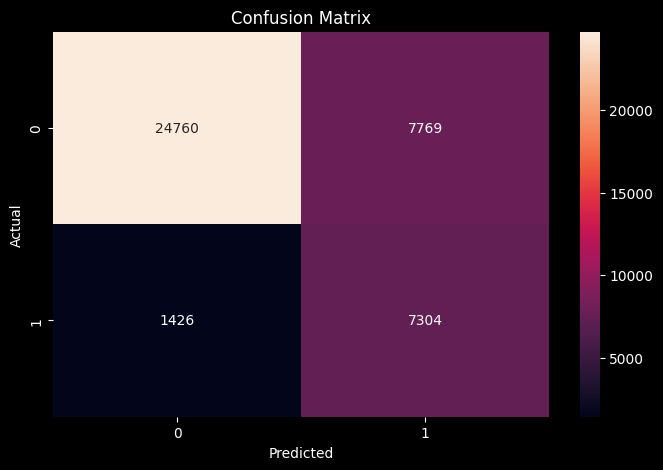

In [18]:
# Plot confusion matrix
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

We can draw some initial conclusions for **the optimized model** using some business-centric measures:

- **False Negative (FN)** is an important measure for churn problem - the business does not want to under-value customers that would exit (1) by classifying them as non-exit (0) - because the cost of new customer acquisition is generally higher than the cost of keeping the customer. Ideally, the model should minimize the FN number. 
- **False Negative Rate, $FNR = \frac{{FN}}{P} = \frac{{FN}}{FN + TP}$** essentially means: out of all **actually exited customers**, what is the percentage of the customers does the model fail to capture. In this baseline model, $FNR = 44.66\%$. This is a very high rate and our goal is to drive that down. 
- The Precision, 
- The AUC

In [19]:
# get model auc score
from sklearn.metrics import roc_auc_score
y_prob_pred = opt_xgb.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_prob_pred)
# auc_score = roc_auc_score(y_test, y_pred2)
print(f'AUC Score: {auc_score}')

AUC Score: 0.8853553267844496
